Загрузите датасет digits с помощью функции load_digits из sklearn.datasets и подготовьте матрицу признаков X и ответы на обучающей выборке y (вам потребуются поля data и target в объекте, который возвращает load_digits).

Для оценки качества далее нужно будет использовать cross_val_score из sklearn.cross_validation с параметром cv=10. Эта функция реализует k-fold cross validation c k равным значению параметра cv. Мы предлагаем использовать k=10, чтобы полученные оценки качества имели небольшой разброс, и было проще проверить полученные ответы. На практике же часто хватает и k=5. Функция cross_val_score будет возвращать numpy.ndarray, в котором будет k чисел - качество в каждом из k экспериментов k-fold cross validation. Для получения среднего значения (которое и будет оценкой качества работы) вызовите метод .mean() у массива, который возвращает cross_val_score.

С небольшой вероятностью вы можете натолкнуться на случай, когда полученное вами качество в каком-то из пунктов не попадет в диапазон, заданный для правильных ответов - в этом случае попробуйте перезапустить ячейку с cross_val_score несколько раз и выбрать наиболее «типичное» значение. Если это не помогает, то где-то была допущена ошибка.

Если вам захочется ускорить вычисление cross_val_score - можете попробовать использовать параметр n_jobs, но будьте осторожны: в одной из старых версий sklearn была ошибка, которая приводила к неверному результату работы cross_val_score при задании n_jobs отличным от 1. Сейчас такой проблемы возникнуть не должно, но проверить, что все в порядке, не будет лишним.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets,model_selection,metrics
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [15]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Создайте DecisionTreeClassifier с настройками по умолчанию и измерьте качество его работы с помощью cross_val_score. Эта величина и будет ответом в пункте 1.

In [23]:
data = datasets.load_digits()
clf_tree = DecisionTreeClassifier(random_state=0)
res = cross_val_score(clf_tree, data.data, data.target, cv=10)
res.mean()

0.8303337234738853

cv scores:
 [0.80540541 0.8579235  0.78453039 0.80555556 0.79888268 0.89385475
 0.89944134 0.81460674 0.8079096  0.83522727]


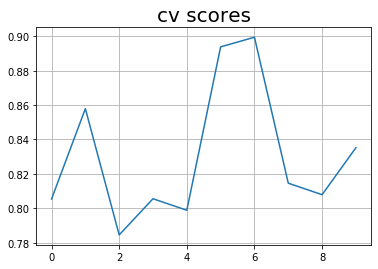

In [37]:
pylab.grid()
pylab.plot(res, label = 'cv scores')
pylab.title('cv scores', fontsize = 20)
print('cv scores:\n', res)

Воспользуйтесь BaggingClassifier из sklearn.ensemble, чтобы обучить бэггинг над DecisionTreeClassifier. Используйте в BaggingClassifier параметры по умолчанию, задав только количество деревьев равным 100.

Качество классификации новой модели - ответ в пункте 2. Обратите внимание, как соотносится качество работы композиции решающих деревьев с качеством работы одного решающего дерева.

In [3]:
X_train,X_test, y_train,  y_test = train_test_split(data.data, data.target, test_size=0.33, random_state=42) 

In [4]:
print(X_train.shape[1])
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

64
(1203,)
(594, 64)
(594,)


In [5]:
clf_bagging = BaggingClassifier(base_estimator = clf_tree, n_estimators = 100, random_state = 0)
clf_bagging.fit(X_train, y_train)
res2 = clf_bagging.score(X_test, y_test)
res2

0.9444444444444444

Теперь изучите параметры BaggingClassifier и выберите их такими, чтобы каждый базовый алгоритм обучался не на всех d признаках, а на $\sqrt{d}$ случайных признаков. Качество работы получившегося классификатора - ответ в пункте 3. Корень из числа признаков - часто используемая эвристика в задачах классификации, в задачах регрессии же часто берут число признаков, деленное на три. Но в общем случае ничто не мешает вам выбирать любое другое число случайных признаков.​	

In [6]:
max_features = int(X_train.shape[1]**0.5)
clf_bagging = BaggingClassifier(base_estimator = clf_tree, n_estimators = 100, max_features = max_features, random_state = 0)
clf_bagging.fit(X_train, y_train)
res3 = clf_bagging.score(X_test, y_test)
res3

0.9494949494949495

Наконец, давайте попробуем выбирать случайные признаки не один раз на все дерево, а при построении каждой вершины дерева. Сделать это несложно: нужно убрать выбор случайного подмножества признаков в BaggingClassifier и добавить его в DecisionTreeClassifier. Какой параметр за это отвечает, можно понять из документации sklearn, либо просто попробовать угадать (скорее всего, у вас сразу получится). Попробуйте выбирать опять же $\sqrt{d}$ признаков. Качество полученного классификатора на контрольной выборке и будет ответом в пункте 4.​	  


In [7]:
clf_bagging = BaggingClassifier(base_estimator = clf_tree, n_estimators = 100, random_state = 42)
clf_bagging.fit(X_train, y_train)
res4 = clf_bagging.score(X_test, y_test)
res4

0.9528619528619529

Полученный в пункте 4 классификатор - бэггинг на рандомизированных деревьях (в которых при построении каждой вершины выбирается случайное подмножество признаков и разбиение ищется только по ним). Это в точности соответствует алгоритму Random Forest, поэтому почему бы не сравнить качество работы классификатора с RandomForestClassifier из sklearn.ensemble. Сделайте это, а затем изучите, как качество классификации на данном датасете зависит от количества деревьев, количества признаков, выбираемых при построении каждой вершины дерева, а также ограничений на глубину дерева. Для наглядности лучше построить графики зависимости качества от значений параметров, но для сдачи задания это делать не обязательно.

In [8]:
clf_random_forest = RandomForestClassifier(n_estimators = 100, random_state=42)
clf_random_forest.fit(X_train, y_train)
res5 = clf_random_forest.score(X_test, y_test)
res5

0.9747474747474747

In [9]:
parameters_grid = {'n_estimators':[int(i) for i in range(1,200,20)], 'random_state':[0,21,42,84]}
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size = 0.2, random_state = 0)
grid_cv = model_selection.GridSearchCV(clf_random_forest, parameters_grid, scoring = 'accuracy', cv = cv)

In [10]:
%time
grid_cv.fit(X_train, y_train)

Wall time: 0 ns


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=0.2,
            train_size=None),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                    

In [11]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.9759336099585062
{'n_estimators': 161, 'random_state': 42}


In [14]:
grid_cv.cv_results_['mean_test_score']

array([0.72697095, 0.74647303, 0.7473029 , 0.73609959, 0.95394191,
       0.95352697, 0.95726141, 0.95228216, 0.96680498, 0.9626556 ,
       0.96473029, 0.96473029, 0.97012448, 0.96763485, 0.97095436,
       0.96721992, 0.96929461, 0.96639004, 0.97385892, 0.96846473,
       0.97302905, 0.96804979, 0.97261411, 0.97302905, 0.97385892,
       0.97012448, 0.97344398, 0.97178423, 0.9746888 , 0.97053942,
       0.97427386, 0.97219917, 0.97344398, 0.97178423, 0.97593361,
       0.97385892, 0.97261411, 0.97095436, 0.97385892, 0.97385892])

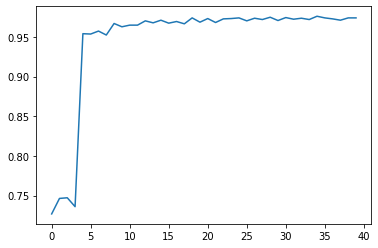

In [19]:
pylab.plot(grid_cv.cv_results_['mean_test_score'])

In [20]:
clf_random_forest_2 = RandomForestClassifier(n_estimators = 161, random_state=42)
clf_random_forest_2.fit(X_train, y_train)
res6 = clf_random_forest_2.score(X_test, y_test)
res6

0.9781144781144782

In [21]:
res5,res6

(0.9747474747474747, 0.9781144781144782)

На основе наблюдений выпишите через пробел номера правильных утверждений из приведенных ниже в порядке возрастания номера (это будет ответ в п.5)

1) Случайный лес сильно переобучается с ростом количества деревьев

2) При очень маленьком числе деревьев (5, 10, 15), случайный лес работает хуже, чем при большем числе деревьев

3) С ростом количества деревьев в случайном лесе, в какой-то момент деревьев становится достаточно для высокого качества классификации, а затем качество существенно не меняется.

4) При большом количестве признаков (для данного датасета - 40, 50) качество классификации становится хуже, чем при малом количестве признаков (5, 10). Это связано с тем, что чем меньше признаков выбирается в каждом узле, тем более различными получаются деревья (ведь деревья сильно неустойчивы к изменениям в обучающей выборке), и тем лучше работает их композиция.

5) При большом количестве признаков (40, 50, 60) качество классификации лучше, чем при малом количестве признаков (5, 10). Это связано с тем, что чем больше признаков - тем больше информации об объектах, а значит алгоритм может делать прогнозы более точно.

6) При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса намного лучше, чем без ограничения глубины, т.к. деревья получаются не переобученными. С ростом глубины деревьев качество ухудшается.

7) При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса заметно хуже, чем без ограничений, т.к. деревья получаются недообученными. С ростом глубины качество сначала улучшается, а затем не меняется существенно, т.к. из-за усреднения прогнозов и различий деревьев их переобученность в бэггинге не сказывается на итоговом качестве (все деревья преобучены по-разному, и при усреднении они компенсируют переобученность друг-друга).

## Ответ
2, 3, 5, 6